In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

num_estimation_trials = 1000

In [18]:
def get_execution_based_aggregation(
    regression_list: list[int],
    testgen_list: list[int],
    verifier_list: list[float],
    gt_list: list[bool],
    sample_indices: list[int],
):
    """
    Get execution-based aggregation. First, we filter the the samples with maximum regression value. 
    Next, we rank the samples via testgen values and get the average pass rate.
    """
    
    sample_list = [
        (regression_list[i], testgen_list[i], verifier_list[i], gt_list[i])
        for i in sample_indices
    ]

    # Sort by regression value
    sample_list.sort(reverse=True, key=lambda x: (x[0], x[1], x[2]))

    # Get the maximum regression value
    max_regression_value = sample_list[0][0]

    # Filter the samples with maximum regression value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in sample_list if x[0] == max_regression_value
    ]
    
    # Sort by testgen value
    filtered_samples.sort(reverse=True, key=lambda x: (x[1]))

    # Get the maximum testgen value
    max_testgen_value = filtered_samples[0][1]

    # Filter the samples with maximum testgen value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in filtered_samples if x[1] == max_testgen_value
    ]

    mean_pass_rate = np.mean(
        [x[3] for x in filtered_samples]
    )    
    return mean_pass_rate


In [19]:
def get_execution_free_aggregation(
    regression_list: list[int],
    testgen_list: list[int],
    verifier_list: list[float],
    gt_list: list[bool],
    sample_indices: list[int],
):
    """
    Get execution-free aggregation. First, we filter the the samples with maximum verifier value and get the average pass rate.
    """
    
    sample_list = [
        (regression_list[i], testgen_list[i], verifier_list[i], gt_list[i])
        for i in sample_indices
    ]

    # Sort by verifier value
    sample_list.sort(reverse=True, key=lambda x: x[2])

    # Get the maximum verifier value
    max_verifier_value = sample_list[0][2]

    # Filter the samples with maximum verifier value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in sample_list if x[2] == max_verifier_value
    ]

    mean_pass_rate = np.mean(
        [x[3] for x in filtered_samples]
    )    
    return mean_pass_rate

In [20]:
def get_hybrid_aggregation(
    regression_list: list[int],
    testgen_list: list[int],
    verifier_list: list[float],
    gt_list: list[bool],
    sample_indices: list[int],
):
    """
    Get gybrid aggregation. First, we rank and filter based on the top-k verifier values. Next, we filter the samples with maximum regression value, followed by maximum testgen values and get the average pass rate.
    """

    sample_list = [
        (regression_list[i], testgen_list[i], verifier_list[i], gt_list[i])
        for i in sample_indices
    ]

    # Sort by verifier value
    sample_list.sort(reverse=True, key=lambda x: (x[2], x[0], x[1]))

    # Get the top-k samples based on verifier value
    top_k = max(3, int(len(sample_list) * 0.5))
    top_k_samples = sample_list[:top_k]

    # Sort by regression value
    top_k_samples.sort(reverse=True, key=lambda x: (x[0], x[2], x[1]))

    # Get the maximum regression value
    max_regression_value = top_k_samples[0][0]

    # Filter the samples with maximum regression value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in top_k_samples if x[0] == max_regression_value
    ]

    # Sort by testgen value
    filtered_samples.sort(reverse=True, key=lambda x: (x[1], x[2]))

    # Get the maximum testgen value
    max_testgen_value = filtered_samples[0][1]

    # Filter the samples with maximum testgen value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in filtered_samples if x[1] == max_testgen_value
    ]

    # Sort by verifier value
    filtered_samples.sort(reverse=True, key=lambda x: (x[2]))

    # Get the maximum verifier value
    max_verifier_value = filtered_samples[0][2]

    # Filter the samples with maximum verifier value
    filtered_samples = [
        (x[0], x[1], x[2], x[3]) for x in filtered_samples if x[2] == max_verifier_value
    ]

    mean_pass_rate = np.mean([x[3] for x in filtered_samples])
    return mean_pass_rate

In [21]:


def subsample_passrates(
    gt_list, regression_list, testgen_list, verifier_list, steps_list
):
    total_programs = len(gt_list)
    assert (
        len(gt_list)
        == len(regression_list)
        == len(testgen_list)
        == len(verifier_list)
        == len(steps_list)
    ), f"Length mismatch: {len(gt_list)}, {len(regression_list)}, {len(testgen_list)}, {len(verifier_list)}, {len(steps_list)}"

    passrate = {}
    executionbased = {}
    executionfree = {}
    hybrid = {}

    for idx in range(1, 27):
        passrate[idx] = []
        executionbased[idx] = []
        executionfree[idx] = []
        hybrid[idx] = []
        for _ in range(num_estimation_trials):  ## num trials
            size = min(total_programs, idx)
            sample_indices = np.random.choice(
                range(total_programs), size=size, replace=False
            )
            sample_gt = [gt_list[i] for i in sample_indices]

            passrate[idx].append(np.any(sample_gt))
            executionbased[idx].append(
                get_execution_based_aggregation(
                    regression_list,
                    testgen_list,
                    verifier_list,
                    gt_list,
                    sample_indices,
                )
            )
            executionfree[idx].append(
                get_execution_free_aggregation(
                    regression_list,
                    testgen_list,
                    verifier_list,
                    gt_list,
                    sample_indices,
                )
            )
            hybrid[idx].append(
                get_hybrid_aggregation(
                    regression_list,
                    testgen_list,
                    verifier_list,
                    gt_list,
                    sample_indices,
                )
            )

    return [
        passrate,
        executionbased,
        executionfree,
        hybrid,
    ]

In [22]:
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
from functools import partial

def process_row(row, subsample_func):
    gt_list = eval(row['gt_rewards'])
    regression_list = eval(row['regression_rates'])
    testgen_list = eval(row['mean_predicted_rewards'])
    verifier_list = eval(row['avg_yes_prob'])
    steps_list = eval(row['step_counts'])
    
    sample_out = subsample_func(gt_list, regression_list, testgen_list, verifier_list, steps_list)
    
    return (sample_out, row.iloc[0])

def parallelize_processing(test_results):
    # Define number of processes to use
    num_processes = mp.cpu_count()
    
    # Create a pool of workers
    pool = mp.Pool(processes=num_processes)
    
    # Create a partial function with the subsample_passrates function already specified
    process_func = partial(process_row, subsample_func=subsample_passrates)
    
    # Process rows in parallel and collect results
    results = list(tqdm(
        pool.imap(process_func, [row for _, row in test_results.iterrows()]), 
        total=test_results.shape[0]
    ))
    
    # Close the pool
    pool.close()
    pool.join()
    
    return results

# Load the data
test_results = load_dataset('R2E-Gym/32B_predictions')['predictions'].to_pandas()

# Run the parallelized processing
df_list = parallelize_processing(test_results)

100%|██████████| 500/500 [00:33<00:00, 14.86it/s]


In [23]:
mean_passrates = []
std_passrates = []
mean_execution_based = []
std_execution_based = []
mean_execution_free = []
std_execution_free = []
mean_hybrid = []
std_hybrid = []

old_regresstestverif=None

for i in tqdm(list(range(1, 27))):
    passrates = []
    execution_based = []
    execution_free = []
    hybrid = []

    for j in range(num_estimation_trials):
        passrate = [x[0][0][i][j] for x in df_list]
        regresstest = [x[0][1][i][j] for x in df_list]
        regressverif = [x[0][2][i][j] for x in df_list]
        regresstestverif = [x[0][3][i][j] for x in df_list]
        passrates.append(np.mean(passrate))
        execution_based.append(np.mean(regresstest))
        execution_free.append(np.mean(regressverif))
        hybrid.append(np.mean(regresstestverif))
        
    mean_passrates.append(
        np.mean(passrates)
    )
    std_passrates.append(np.std(passrates))

    mean_execution_based.append(
        np.mean(execution_based)
    )
    std_execution_based.append(np.std(execution_based))

    mean_execution_free.append(
        np.mean(execution_free)
    )

    std_execution_free.append(np.std(execution_free))
    
    mean_hybrid.append(
        np.mean(hybrid)
    )
    std_hybrid.append(np.std(hybrid))


mean_passrates = np.array(mean_passrates) * 100
std_passrates = np.array(std_passrates) * 100
mean_execution_based = np.array(mean_execution_based) * 100
std_execution_based = np.array(std_execution_based) * 100
mean_execution_free = np.array(mean_execution_free) * 100
std_execution_free = np.array(std_execution_free) * 100
mean_hybrid = np.array(mean_hybrid) * 100
std_hybrid = np.array(std_hybrid) * 100


100%|██████████| 26/26 [00:20<00:00,  1.28it/s]


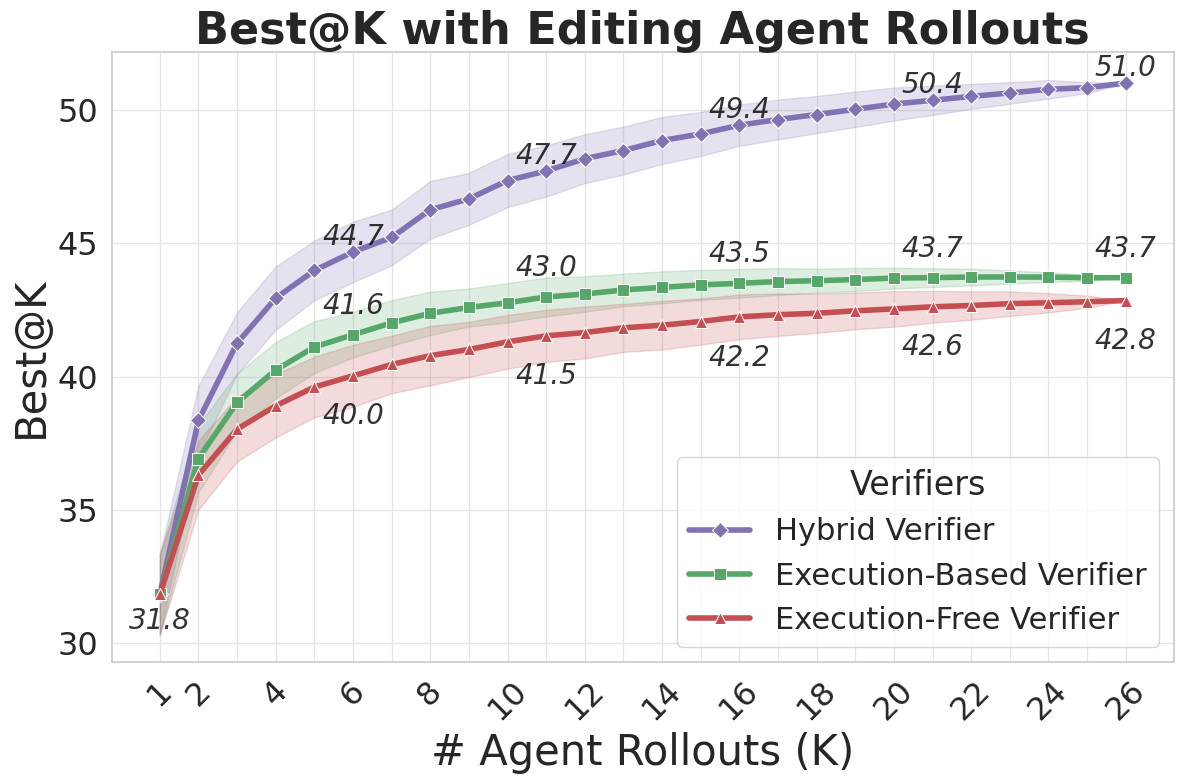

In [24]:
# X-axis values
x = range(1, 27)

# Start plotting
plt.figure(figsize=(12, 8))

# Set style
sns.set(style="whitegrid")

# Lighten the grid
sns.set_style("whitegrid", {"grid.color": ".9"})

def annotate_line(x, y, label, offset):
    for i in range(len(x)):
        if (
            i % 5 == 0 or i == len(x) - 1
        ):  
            if i == 0:
                continue
            plt.annotate(
                f"{y[i]:.1f}",
                (x[i], y[i]),
                textcoords="offset points",
                xytext=(0, offset),  
                ha="center",
                fontsize=20,
                fontstyle="italic",  
                color="black",  
                alpha=0.8,  
            )

plt.annotate(
    f"{mean_passrates[0]:.1f}",
    (x[0], mean_passrates[0]),
    textcoords="offset points",
    xytext=(0, -25),  
    ha="center",
                fontsize=20,
                fontstyle="italic",  
                color="black",  
                alpha=0.8,  
)


plot4 = sns.lineplot(
    x=x,
    y=mean_hybrid,
    label="Hybrid Verifier",
    color="m",
    marker="D",
    markersize=8, lw=4
)
plt.fill_between(
    x,
    np.array(mean_hybrid) - np.array(std_hybrid),
    np.array(mean_hybrid) + np.array(std_hybrid),
    alpha=0.2,
    color="m",
)
annotate_line(x, mean_hybrid, "Hybrid Verifier", 5)

plot2 = sns.lineplot(
    x=x,
    y=mean_execution_based,
    label="Execution-Based Verifier",
    color="g",
    marker="s",
    markersize=8, lw=4
)
plt.fill_between(
    x,
    np.array(mean_execution_based) - np.array(std_execution_based),
    np.array(mean_execution_based) + np.array(std_execution_based),
    alpha=0.2,
    color="g",
)
annotate_line(x, mean_execution_based, "Test Agent Verifier", 15)

plot3 = sns.lineplot(
    x=x,
    y=mean_execution_free,
    label="Execution-Free Verifier",
    color="r",
    marker="^",
    markersize=8, lw=4
)
plt.fill_between(
    x,
    np.array(mean_execution_free) - np.array(std_execution_free),
    np.array(mean_execution_free) + np.array(std_execution_free),
    alpha=0.2,
    color="r",
)
annotate_line(x, mean_execution_free, "Trajectory Verifier", -35)

# Set x-ticks
plt.xticks(
    ticks=x,
    labels=[str(i) if (i % 2 == 0 or i == 1) else "" for i in range(1, 27)],
    fontsize=23,
    rotation=45,
)
plt.yticks(fontsize=23)

# Labels and title with font adjustments
plt.xlabel("# Agent Rollouts (K)", fontsize=30)
plt.ylabel("Best@K", fontsize=30)
plt.title("Best@K with Editing Agent Rollouts", fontsize=32, fontweight="bold")

# Separate handles and labels for the legends
handles_pass, labels_pass = plot4.get_legend_handles_labels()

handles_verifiers, labels_verifiers = [], []
for plot in [plot4][:1]:
    h, l = plot.get_legend_handles_labels()
    handles_verifiers.extend(h)
    labels_verifiers.extend(l)

legend_verifiers = plt.legend(
    handles=handles_verifiers,
    labels=labels_verifiers,
    title="Verifiers",
    loc="lower right",
    fontsize=22,
    title_fontsize=24,
)

# Save and finalize the plot
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()
